In [41]:
from pathlib import Path   
import os                  

import numpy as np
import matplotlib.pyplot as plt
import cv2                # For image processing

# TensorFlow and Keras for deep learning
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn for data preprocessing and model evaluation
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical  # To convert a class vector (integers) to a binary class matrix
from sklearn.metrics import classification_report, confusion_matrix

In [42]:
def process_images_from_directory(directory, label, size):
    
    images_list = []
    for image_path in directory.iterdir():
        try:
            if image_path.suffix == '.png':
                # Read the image using OpenCV
                image = cv2.imread(str(image_path))

                # Convert the image to RGB (OpenCV uses BGR by default)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Resize the imagea
                image_resized = cv2.resize(image_rgb, (size, size))

                images_list.append(image_resized)
                label.append(0 if directory.name == 'Parasitized' else 1)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    return images_list

In [43]:
dataset_path_parasitized = Path("C:\\Users\\SaiSu\\Downloads\\archive (24)\\cell_images\\Parasitized")
dataset_path_uninfected  = Path("C:\\Users\\SaiSu\\Downloads\\archive (24)\\cell_images\\Uninfected")

In [44]:
SIZE      = 64    
dataset   = []    
label     = []    

dataset = process_images_from_directory(dataset_path_parasitized, label, SIZE)
dataset.extend(process_images_from_directory(dataset_path_uninfected, label, SIZE))

### Data Exploratory Analysis (EDA)


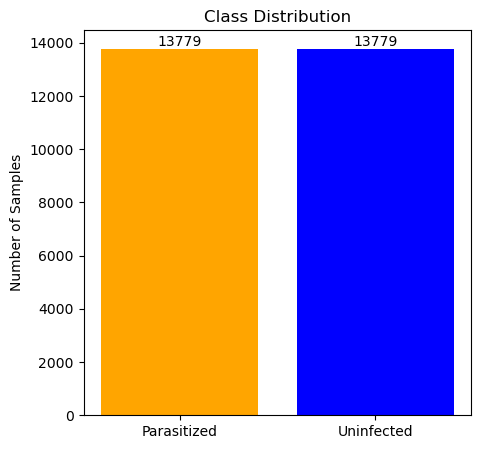

In [45]:
# Data for plotting
categories = ['Parasitized', 'Uninfected']
values     = [label.count(0), label.count(1)]
colors     = ['orange', 'blue']  

plt.figure(figsize = (5, 5))  
bars = plt.bar(categories, values, color = colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.title('Class Distribution')
plt.ylabel('Number of Samples')

plt.show()

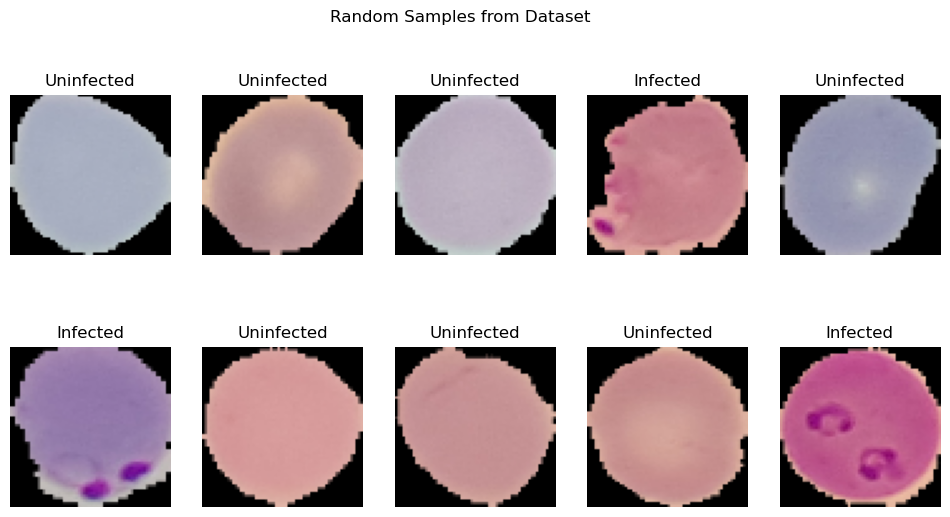

In [46]:
# Display some sample images:
def display_samples(samples, labels, title):
    plt.figure(figsize=(12, 6))
    for index, (image, label) in enumerate(zip(samples, labels)):
        plt.subplot(2, 5, index + 1)
        plt.imshow(image)
        plt.title('Infected' if label == 0 else 'Uninfected')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

samples_to_display = 10

random_indices = np.random.choice(len(dataset), samples_to_display, replace=False)
samples = [dataset[i] for i in random_indices]
sample_labels = [label[i] for i in random_indices]

display_samples(samples, sample_labels, "Random Samples from Dataset")

### Training & Validation

In [47]:
# Splitting the Dataset
X = np.array(dataset)
Y = to_categorical(np.array(label))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [48]:
# Data Augmentation
# Define the ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range    = 15,
    width_shift_range = 0.2,
    height_shift_range= 0.2,
    zoom_range        = 0.2,
    shear_range = 0.2,
    horizontal_flip   = True,
    vertical_flip     = True,
)

# to create the augmented data generator
augmented_data = data_generator.flow(X_train, y_train, batch_size = 64,shuffle = True)

In [49]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22046, 64, 64, 3)
y_train shape: (22046, 2)
X_test shape: (5512, 64, 64, 3)
y_test shape: (5512, 2)


### EfficientNetB3

In [62]:
import keras
from keras.applications import EfficientNetB3 

In [63]:
import keras
from keras.applications import EfficientNetB3

def dense_block(input_tensor, num_neurons):
    x = keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001))(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    return x

# Load the EfficientNetB3 model without the top (classification) layers
efficientnet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the convolutional layers to prevent training
for layer in efficientnet.layers:
    layer.trainable = False

# Flatten the output of EfficientNetB3
x = keras.layers.Flatten()(efficientnet.output)

# Add dense layers
x = dense_block(x, 512)
x = dense_block(x, 256)

# Output layer
out = keras.layers.Dense(2, activation='sigmoid')(x)

In [60]:
# Create the model
model = keras.Model(inputs=efficientnet.input, outputs=out)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 64, 64, 3)            0         ['input_7[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 64, 64, 3)            7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 64, 64, 3)            0         ['normalization[0][0]'] 

                                                                                                  
 block2a_expand_conv (Conv2  (None, 32, 32, 144)          3456      ['block1b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2a_expand_bn (BatchNo  (None, 32, 32, 144)          576       ['block2a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2a_expand_activation   (None, 32, 32, 144)          0         ['block2a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2a_d

 block2c_expand_conv (Conv2  (None, 16, 16, 192)          6144      ['block2b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block2c_expand_bn (BatchNo  (None, 16, 16, 192)          768       ['block2c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block2c_expand_activation   (None, 16, 16, 192)          0         ['block2c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block2c_dwconv (DepthwiseC  (None, 16, 16, 192)          1728      ['block2c_expand_activation[0]
 onv2D)   

 D)                                                                                               
                                                                                                  
 block3b_expand_bn (BatchNo  (None, 8, 8, 288)            1152      ['block3b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block3b_expand_activation   (None, 8, 8, 288)            0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_dwconv (DepthwiseC  (None, 8, 8, 288)            7200      ['block3b_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 block4a_expand_conv (Conv2  (None, 8, 8, 288)            13824     ['block3c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4a_expand_bn (BatchNo  (None, 8, 8, 288)            1152      ['block4a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4a_expand_activation   (None, 8, 8, 288)            0         ['block4a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4a_dwconv_pad (ZeroPa  (None, 9, 9, 288)            0         ['block4a_expand_activation[0]
 dding2D) 

 D)                                                                                               
                                                                                                  
 block4c_expand_bn (BatchNo  (None, 4, 4, 576)            2304      ['block4c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4c_expand_activation   (None, 4, 4, 576)            0         ['block4c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4c_dwconv (DepthwiseC  (None, 4, 4, 576)            5184      ['block4c_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 block4e_expand_conv (Conv2  (None, 4, 4, 576)            55296     ['block4d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block4e_expand_bn (BatchNo  (None, 4, 4, 576)            2304      ['block4e_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block4e_expand_activation   (None, 4, 4, 576)            0         ['block4e_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block4e_dwconv (DepthwiseC  (None, 4, 4, 576)            5184      ['block4e_expand_activation[0]
 onv2D)   

 rmalization)                                                                                     
                                                                                                  
 block5b_expand_activation   (None, 4, 4, 816)            0         ['block5b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5b_dwconv (DepthwiseC  (None, 4, 4, 816)            20400     ['block5b_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5b_bn (BatchNormaliza  (None, 4, 4, 816)            3264      ['block5b_dwconv[0][0]']      
 tion)                                                                                            
          

 block5d_expand_bn (BatchNo  (None, 4, 4, 816)            3264      ['block5d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5d_expand_activation   (None, 4, 4, 816)            0         ['block5d_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block5d_dwconv (DepthwiseC  (None, 4, 4, 816)            20400     ['block5d_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block5d_bn (BatchNormaliza  (None, 4, 4, 816)            3264      ['block5d_dwconv[0][0]']      
 tion)    

                                                                                                  
 block6a_expand_bn (BatchNo  (None, 4, 4, 816)            3264      ['block6a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6a_expand_activation   (None, 4, 4, 816)            0         ['block6a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6a_dwconv_pad (ZeroPa  (None, 7, 7, 816)            0         ['block6a_expand_activation[0]
 dding2D)                                                           [0]']                         
                                                                                                  
 block6a_d

 block6c_expand_bn (BatchNo  (None, 2, 2, 1392)           5568      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_expand_activation   (None, 2, 2, 1392)           0         ['block6c_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6c_dwconv (DepthwiseC  (None, 2, 2, 1392)           34800     ['block6c_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6c_bn (BatchNormaliza  (None, 2, 2, 1392)           5568      ['block6c_dwconv[0][0]']      
 tion)    

                                                                                                  
 block6e_expand_bn (BatchNo  (None, 2, 2, 1392)           5568      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6e_expand_activation   (None, 2, 2, 1392)           0         ['block6e_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block6e_dwconv (DepthwiseC  (None, 2, 2, 1392)           34800     ['block6e_expand_activation[0]
 onv2D)                                                             [0]']                         
                                                                                                  
 block6e_b

 D)                                                                                               
                                                                                                  
 block7a_expand_bn (BatchNo  (None, 2, 2, 1392)           5568      ['block7a_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block7a_expand_activation   (None, 2, 2, 1392)           0         ['block7a_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block7a_dwconv (DepthwiseC  (None, 2, 2, 1392)           12528     ['block7a_expand_activation[0]
 onv2D)                                                             [0]']                         
          

 top_activation (Activation  (None, 2, 2, 1536)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 flatten_6 (Flatten)         (None, 6144)                 0         ['top_activation[0][0]']      
                                                                                                  
 dense_18 (Dense)            (None, 512)                  3146240   ['flatten_6[0][0]']           
                                                                                                  
 batch_normalization_76 (Ba  (None, 512)                  2048      ['dense_18[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 dropout_4

In [23]:
# Training the Model without Early Stopping
history = model.fit(
    augmented_data,
    verbose=1,
    epochs=45,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 64  # Number of batches per epoch
)

Epoch 1/45
344/344 [==============================] - 256s 745ms/step - loss: 0.3126 - accuracy: 0.8784 - val_loss: 0.2728 - val_accuracy: 0.8917
Epoch 2/45
344/344 [==============================] - 260s 754ms/step - loss: 0.3139 - accuracy: 0.8769 - val_loss: 0.2779 - val_accuracy: 0.8861
Epoch 3/45
344/344 [==============================] - 267s 777ms/step - loss: 0.3117 - accuracy: 0.8767 - val_loss: 0.2405 - val_accuracy: 0.9086
Epoch 4/45
344/344 [==============================] - 263s 764ms/step - loss: 0.3053 - accuracy: 0.8819 - val_loss: 0.2489 - val_accuracy: 0.9075
Epoch 5/45
344/344 [==============================] - 261s 760ms/step - loss: 0.3136 - accuracy: 0.8756 - val_loss: 0.2838 - val_accuracy: 0.8833
Epoch 6/45
344/344 [==============================] - 125s 364ms/step - loss: 0.3083 - accuracy: 0.8840 - val_loss: 0.3119 - val_accuracy: 0.8670
Epoch 7/45
344/344 [==============================] - 116s 336ms/step - loss: 0.3118 - accuracy: 0.8787 - val_loss: 0.2386 -

In [24]:
# Evaluate the model
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(f"Test Loss: {scores[0]:.5f}")

# Predict classes with the model
predictions = model.predict(np.array(X_test))
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to single-column format
y_test_single_column = np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print(classification_report(y_test_single_column, predicted_classes))
print(confusion_matrix(y_test_single_column, predicted_classes))

Accuracy: 87.14%
Test Loss: 0.31006
173/173 [==============================] - 30s 171ms/step
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      2703
           1       0.81      0.98      0.89      2809

    accuracy                           0.87      5512
   macro avg       0.89      0.87      0.87      5512
weighted avg       0.89      0.87      0.87      5512

[[2057  646]
 [  63 2746]]


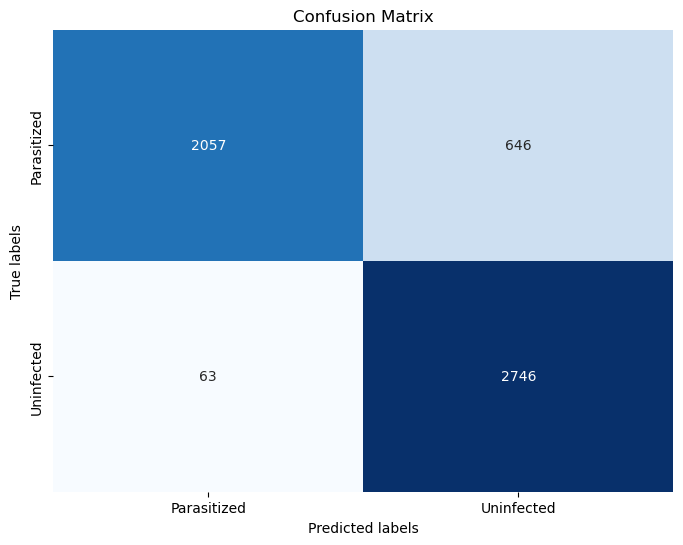

In [25]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_single_column, predicted_classes)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.show()

In [26]:
# Calculate the average training loss over all epochs
average_train_loss = np.mean(history.history['loss'])

# Get the training loss from the last epoch
final_train_loss = history.history['loss'][-1]

print(f"Average Training Loss: {average_train_loss:.5f}")
print(f"Final Training Loss: {final_train_loss:.5f}")

Average Training Loss: 0.30980
Final Training Loss: 0.31405


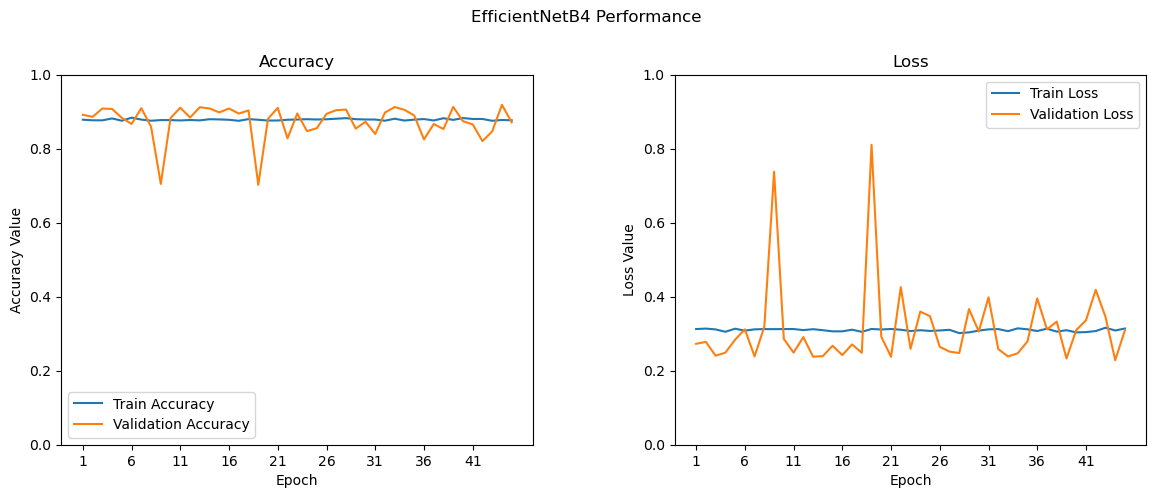

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('EfficientNetB4 Performance', fontsize=12)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Extract the number of epochs and create a list of epoch numbers
    max_epoch = len(history.history['accuracy'])
    epoch_list = list(range(1, max_epoch + 1))

    # Plot training and validation accuracy
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")
    ax1.set_ylim([0, 1])  # Set y-axis limits to [0, 1]

    # Plot training and validation loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend(loc="best")
    ax2.set_ylim([0, 1])  # Set y-axis limits to [0, 1]

    # Display the plots
    plt.show()

# Call the function to plot
plot_training_history(history)
